# Cryptocurrency Price Prediction

In [1]:
!pip install --quiet yfinance

In [2]:
!python --version

Python 3.10.12


### Importing Libraries

In [3]:
# Import Libraries
import numpy as np
import pandas as pd
import datetime as dt

# Data Scrape Package
import pandas_datareader.data as pdr
import yfinance as yf
yf.pdr_override()

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Scaling Package
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Plotting
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}') # To check what gpu !nvidia-smi

Using device: cuda


### Loading the Cryptocurrency Data

In [5]:
# Load the Data
y_symbols = 'BTC-USD'
startdate = dt.datetime(2021,1,1)
enddate = dt.datetime(2023,6,29)
df = pdr.get_data_yahoo(y_symbols, start = startdate, end = enddate).reset_index()

# convert date field from string to Date format
df['Date'] = pd.to_datetime(df.Date)

[*********************100%%**********************]  1 of 1 completed


In [6]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
1,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
3,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
4,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782
...,...,...,...,...,...,...,...
904,2023-06-24,30708.738281,30804.148438,30290.146484,30548.695312,30548.695312,12147822496
905,2023-06-25,30545.150391,31041.271484,30327.943359,30480.261719,30480.261719,12703464114
906,2023-06-26,30480.523438,30636.029297,29955.744141,30271.130859,30271.130859,16493186997
907,2023-06-27,30274.320312,31006.787109,30236.650391,30688.164062,30688.164062,16428827944


In [7]:
df = df[['Date','Close']]

In [8]:
df

,Date,Close
0,2021-01-01,29374.152344
1,2021-01-02,32127.267578
2,2021-01-03,32782.023438
3,2021-01-04,31971.914062
4,2021-01-05,33992.429688
...,...,...
904,2023-06-24,30548.695312
905,2023-06-25,30480.261719
906,2023-06-26,30271.130859
907,2023-06-27,30688.164062


### Data Preprocessing - Splitting/Normalization

In [9]:
# Splitting the data into 80% training and 20% testing
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_data, test_data = df[0:train_size], df[train_size:]

# This is so we can get the date
test_data_copy = test_data.copy()

train_data.shape, test_data.shape

((727, 2), (182, 2))

In [10]:
# Deleting the date, we only need the close price
del train_data['Date']
del test_data['Date']

In [11]:
# Normalizing the data
scaler = StandardScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [12]:
class SlidingWindowDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = torch.from_numpy(data).float()
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        window = self.data[idx:idx + self.window_size]
        target = self.data[idx + self.window_size]
        return window, target

In [13]:
window_size = 30 # define the size of the sliding window
train_dataset = SlidingWindowDataset(train_data, window_size=window_size)
test_dataset = SlidingWindowDataset(test_data, window_size=window_size)

In [14]:
batch_size = 32 # set the batch size for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # True
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Example of sliding window function


In [15]:
### Example of sliding window function
# Generate some non-random data
dummy_train_data = np.arange(1, 81).reshape(-1, 1) # 80% training
dummy_test_data = np.arange(81, 101).reshape(-1, 1) # 20% testing

# Set the window size
dummy_window_size = 15

# Create the datasets and dataloaders
dummy_train_dataset = SlidingWindowDataset(dummy_train_data, dummy_window_size)
dummy_test_dataset = SlidingWindowDataset(dummy_test_data, dummy_window_size)

train_dataloader = DataLoader(dummy_train_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(dummy_test_dataset, batch_size=1, shuffle=False)

# Print a few samples from the training dataloader
for i, (window, target) in enumerate(train_dataloader):
    print(f"Window {i+1}:")
    print(window)
    print(f"Target {i+1}:")
    print(target)
    print("-" * 20)
    if i == 4:  # print only first 5 windows
        break

Window 1:
tensor([[[ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 7.],
         [ 8.],
         [ 9.],
         [10.],
         [11.],
         [12.],
         [13.],
         [14.],
         [15.]]])
Target 1:
tensor([[16.]])
--------------------
Window 2:
tensor([[[ 2.],
         [ 3.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 7.],
         [ 8.],
         [ 9.],
         [10.],
         [11.],
         [12.],
         [13.],
         [14.],
         [15.],
         [16.]]])
Target 2:
tensor([[17.]])
--------------------
Window 3:
tensor([[[ 3.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 7.],
         [ 8.],
         [ 9.],
         [10.],
         [11.],
         [12.],
         [13.],
         [14.],
         [15.],
         [16.],
         [17.]]])
Target 3:
tensor([[18.]])
--------------------
Window 4:
tensor([[[ 4.],
         [ 5.],
         [ 6.],
         [ 7.],
         [ 8.],
         [ 9.

### Creating GRU Model

In [16]:
# Hyperparameters
input_size = 1
hidden_size = 32
num_layers = 1
output_size = 1
learning_rate = 0.001

In [17]:
# Create GRU model
class GRUNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(GRUNet, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers
    # GRU
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True) # if batch_first = True then x should be [batch_size, seq_len, num_feature]
    self.output_layer = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    hidden_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    out, _ = self.gru(x, hidden_state)
    # out: batch_size, seq_len, hidden_size
    out = self.output_layer(out[:, -1, :])
    return out

In [18]:
torch.manual_seed(42)
model = GRUNet(input_size, hidden_size, num_layers, output_size).to(device)
model

GRUNet(
  (gru): GRU(1, 32, batch_first=True)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [19]:
model.state_dict()

OrderedDict([('gru.weight_ih_l0',
              tensor([[ 0.1352],
                      [ 0.1467],
                      [-0.0414],
                      [ 0.1624],
                      [-0.0387],
                      [ 0.0357],
                      [-0.0861],
                      [ 0.1038],
                      [ 0.1558],
                      [-0.1297],
                      [ 0.1537],
                      [ 0.0331],
                      [ 0.1306],
                      [ 0.0239],
                      [ 0.0852],
                      [-0.0250],
                      [ 0.1363],
                      [ 0.0261],
                      [-0.0825],
                      [ 0.0451],
                      [-0.0814],
                      [-0.0207],
                      [-0.0718],
                      [ 0.1173],
                      [-0.1395],
                      [-0.0815],
                      [-0.0499],
                      [-0.1063],
                      [ 0.0167],
         

In [20]:
# Create loss function
loss_fn = nn.MSELoss()
# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training the Model

In [21]:
# Create list to store training and testing loss
train_loss_history = []
test_loss_history = []

# Number of epochs for training and testing
num_epochs = 100

### Training Loop
for epoch in range(num_epochs):

  # Set model to training model
  model.train()

  # Initialize training loss
  train_loss = 0.0

  for batch_idx, (inputs, targets) in enumerate(train_loader):
    # Move inputs and targets to device
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Calculate loss
    loss = loss_fn(outputs, targets)

    # Zero out the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    # Update training loss
    train_loss += loss.item()

  # Calculate average training loss for epoch
  train_loss /= len(train_loader)
  train_loss_history.append(train_loss)

  ### Testing loop

  # Set model to evaluation mode
  model.eval()

  # Initialize testing loss
  test_loss = 0.0

  # Disable gradient computation to save memory
  with torch.inference_mode():

    for batch_idx, (inputs, targets) in enumerate(test_loader):
      # Move inputs and targets to device
      inputs, targets = inputs.to(device), targets.to(device)

      # Forward pass
      outputs = model(inputs)

      # Calculate loss
      loss = loss_fn(outputs, targets)

      # Update testing loss
      test_loss += loss.item()

  ## Calculate average testing loss for epoch
  test_loss /= len(test_loader)
  test_loss_history.append(test_loss)

  print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

Epoch 1/100, Train Loss: 0.772243, Test Loss: 0.320564
Epoch 2/100, Train Loss: 0.345245, Test Loss: 0.019103
Epoch 3/100, Train Loss: 0.059998, Test Loss: 0.036733
Epoch 4/100, Train Loss: 0.037998, Test Loss: 0.015624
Epoch 5/100, Train Loss: 0.032759, Test Loss: 0.015213
Epoch 6/100, Train Loss: 0.028868, Test Loss: 0.013644
Epoch 7/100, Train Loss: 0.026662, Test Loss: 0.014411
Epoch 8/100, Train Loss: 0.024935, Test Loss: 0.011705
Epoch 9/100, Train Loss: 0.023210, Test Loss: 0.009194
Epoch 10/100, Train Loss: 0.022169, Test Loss: 0.008681
Epoch 11/100, Train Loss: 0.021124, Test Loss: 0.007974
Epoch 12/100, Train Loss: 0.020129, Test Loss: 0.008951
Epoch 13/100, Train Loss: 0.019553, Test Loss: 0.007977
Epoch 14/100, Train Loss: 0.019035, Test Loss: 0.007047
Epoch 15/100, Train Loss: 0.018285, Test Loss: 0.005857
Epoch 16/100, Train Loss: 0.018065, Test Loss: 0.004677
Epoch 17/100, Train Loss: 0.017782, Test Loss: 0.005067
Epoch 18/100, Train Loss: 0.017487, Test Loss: 0.004891
E

#### Plotting the Loss


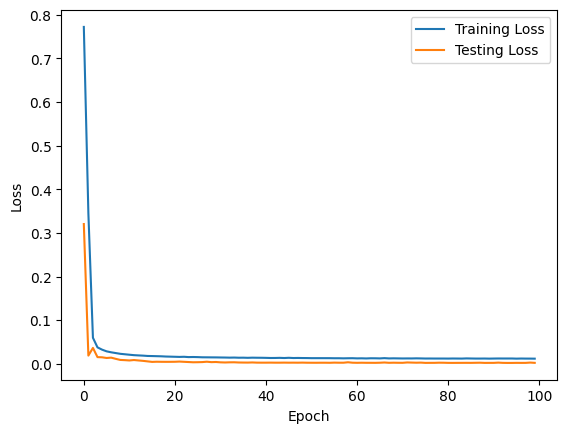

In [22]:
# Plot the training and testing loss over time
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Testing Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Evaluating the Model

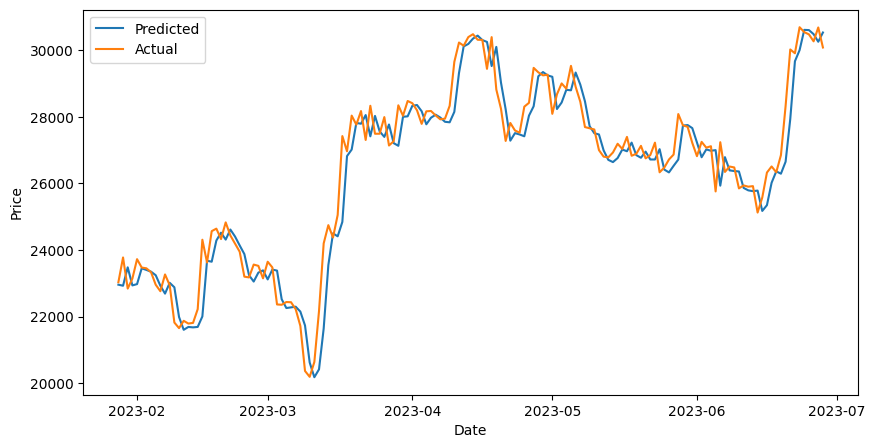

In [23]:
# Set model to evaluation mode
model.eval()

# Make predictions on test data
test_predictions = []
with torch.inference_mode(): # Disable gradient computation to save memory
    for batch_idx, (inputs, targets) in enumerate(test_loader):
      inputs, targets = inputs.to(device), targets.to(device)

      outputs = model(inputs) # Forward pass
      test_predictions.append(outputs.cpu().numpy()) # Convert predicted values back to cpu for pandas

test_predictions = np.concatenate(test_predictions)

# Inverse transform the data to get back to original units
test_predictions = scaler.inverse_transform(test_predictions)

# Create a DataFrame with predicted and actual values
predictions_df = pd.DataFrame({
    'Date': test_data_copy['Date'][window_size:],
    'Actual': test_data_copy['Close'][window_size:],
    'Predicted': test_predictions.reshape(-1)
})

# Plot the predicted values against the actual values
plt.figure(figsize=(10,5))
plt.plot(predictions_df['Date'], predictions_df['Predicted'], label='Predicted')
plt.plot(predictions_df['Date'], predictions_df['Actual'], label='Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [24]:
# Calculate RMSE
rmse = math.sqrt(mean_squared_error(predictions_df['Actual'], predictions_df['Predicted']))
print(f'RMSE: {rmse:.4f}')
mae = mean_absolute_error(predictions_df['Actual'], predictions_df['Predicted'])
print(f'MAE: {mae:.4f}')

RMSE: 686.5399
MAE: 474.2573


#### Comparison of original close and predicted close price

In [25]:
# Print the DataFrame
# print(predictions_df.head())
predictions_df

,Date,Actual,Predicted
757,2023-01-28,23031.089844,22956.324219
758,2023-01-29,23774.566406,22925.539062
759,2023-01-30,22840.138672,23478.455078
760,2023-01-31,23139.283203,22935.101562
761,2023-02-01,23723.769531,22973.890625
...,...,...,...
904,2023-06-24,30548.695312,30615.810547
905,2023-06-25,30480.261719,30609.207031
906,2023-06-26,30271.130859,30487.697266
907,2023-06-27,30688.164062,30258.828125


### Saving and loading the GRU Model


#### Saving the model

In [26]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "GRU_BTC_MODEL.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/GRU_BTC_MODEL.pth


#### Loading the Model

In [27]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model load path
MODEL_NAME = "GRU_BTC_MODEL.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [28]:
# # Hyperparameters
# input_size = 1
# hidden_size = 16
# num_layers = 1
# output_size = 1
# learning_rate = 0.001

In [29]:
# Create GRU model
class GRUNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(GRUNet, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers
    # GRU
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True) # if batch_first = True then x should be [batch_size, seq_len, num_feature]
    self.output_layer = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    hidden_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    out, _ = self.gru(x, hidden_state)
    # out: batch_size, seq_len, hidden_size
    out = self.output_layer(out[:, -1, :])
    return out

In [30]:
# Instantiate a new instance of the model
torch.manual_seed(42)
loaded_model = GRUNet(input_size, hidden_size, num_layers, output_size).to(device)

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [31]:
# Put the loaded model into evaluation mode
loaded_model.eval()

GRUNet(
  (gru): GRU(1, 32, batch_first=True)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

#### Predicting the next day close price

In [32]:
# Load the Data
y_symbols = 'BTC-USD'
startdate = dt.datetime(2018,1,1)
enddate = dt.datetime(2023,6,29)
new_df = pdr.get_data_yahoo(y_symbols, start = startdate, end = enddate).reset_index()

# Take only the Close price
new_df = new_df[['Close']]

[*********************100%%**********************]  1 of 1 completed


In [33]:
new_df

,Close
0,13657.200195
1,14982.099609
2,15201.000000
3,15599.200195
4,17429.500000
...,...
2000,30548.695312
2001,30480.261719
2002,30271.130859
2003,30688.164062


In [34]:
# Set up window size
window_size = 30
# Scalar
scaler = StandardScaler()

pred_train_size = int(len(new_df) * 0.8)
pred_train_data = new_df[0:pred_train_size]
pred_train_data = scaler.fit_transform(pred_train_data)

In [35]:
# Get the last window_size days of closing prices from the new_df dataframe
last_window_size_days = new_df[-window_size:]
# Normalize the data
last_window_size_days = scaler.transform(last_window_size_days)
# Convert into tensor
last_window_size_days = torch.from_numpy(last_window_size_days).float().to(device)

# Use the last window_size days to predict the next day's closing price
model.eval()
# NOTE: This is for when you loaded a model
# loaded_model.eval()
with torch.inference_mode():
    pred = model(last_window_size_days.unsqueeze(0))
    # NOTE: This is for when you loaded a model
    # pred = loaded_model(last_window_size_days.unsqueeze(0))
# Denormalize the predicted price
pred = scaler.inverse_transform(pred.cpu().numpy())

# Print the predicted price
print(f"Predicted price for the next day: {pred[0][0]}")

Predicted price for the next day: 30186.548828125


### Naive Model for Baseline

In [36]:
# Create a copy of the test data
naive_data = test_data_copy.copy()

# Shift the Close column by 1 day to get the previous day's closing price
naive_data['Previous_Close'] = naive_data['Close'].shift(1)

# Drop the first row since it doesn't have a previous day's closing price
naive_data = naive_data.iloc[30:].reset_index(drop=True) # naive_data.dropna(inplace=True)

# Calculate the RMSE of the naive model
rmse_naive = math.sqrt(mean_squared_error(naive_data['Close'], naive_data['Previous_Close']))
print('Naive RMSE:', rmse_naive)

Naive RMSE: 659.6952715351681


In [37]:
naive_data

,Date,Close,Previous_Close
0,2023-01-28,23031.089844,23078.728516
1,2023-01-29,23774.566406,23031.089844
2,2023-01-30,22840.138672,23774.566406
3,2023-01-31,23139.283203,22840.138672
4,2023-02-01,23723.769531,23139.283203
...,...,...,...
147,2023-06-24,30548.695312,30695.468750
148,2023-06-25,30480.261719,30548.695312
149,2023-06-26,30271.130859,30480.261719
150,2023-06-27,30688.164062,30271.130859


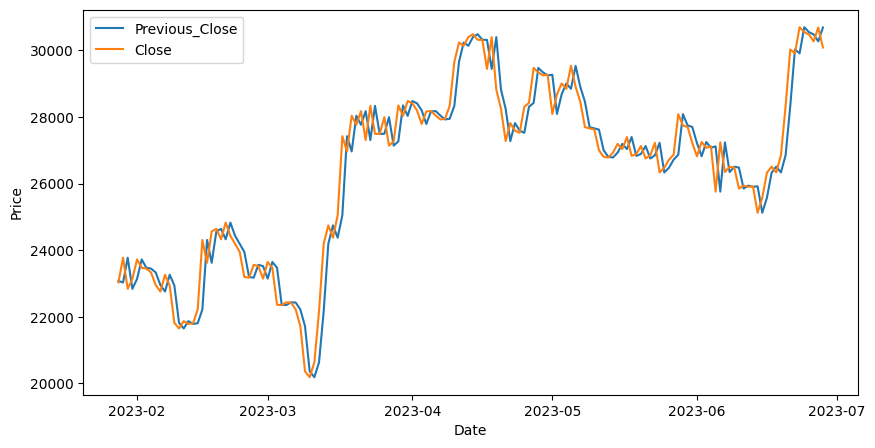

In [38]:
# Plot the Close and Previous_Close
plt.figure(figsize=(10,5))
plt.plot(naive_data['Date'], naive_data['Previous_Close'], label='Previous_Close')
plt.plot(naive_data['Date'], naive_data['Close'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()